# Imports and Configuration

In [1]:
import glob
import os
from joblib import dump, load
import pandas as pd
import numpy as np
import shutil
import joblib
from skimage import io, color, filters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif

In [2]:
# Grid-based dataset csv file
DATASET_CSV_PATH = '../dataset-numpy'

# Scaler location
SCALER_PATH = '../classifiers/scaler.joblib'

# KNN Classifier location
KNN_CLASSIFIER_PATH = '../classifiers/knn_classifier.joblib'

# Temp directory
TEMP_DIR_PATH = '../temp'

# Grid Based Model

It's always wise to check that we actually have the data we expect. After importing the datasets we created previously from Github, we should have the data for every grid size. Given the initial dataset, we should have 1920 rows (as it consists of 480 postal codes, which is 1920 single digits) for each grid size.

Let's load a dataset from the csv file into a DataFrame and describe it, to see if we indeed retrieved everything in properly.

In [3]:
# Import the dataset into a DataFrame
df_grid = pd.read_csv(DATASET_CSV_PATH + '/grid_dataset_4.csv')

# Describe the dataset to see if it's been loaded in properly
df_grid.describe()

,label,sum_1,sum_2,sum_3,sum_4,sum_5,sum_6,sum_7,sum_8,sum_9,sum_10,sum_11,sum_12,sum_13,sum_14,sum_15,sum_16
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,4.532813,2.235937,39.644792,36.097396,3.843750,4.896354,34.896875,33.200521,4.411458,3.408854,30.311979,36.148438,6.444792,1.163542,35.611979,37.214583,6.365625
std,2.868122,3.517256,12.735939,14.626580,7.979361,5.633055,15.674676,17.059070,6.696306,5.611908,18.605251,14.065148,6.858434,2.631299,13.570497,15.269706,9.307086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,34.000000,27.000000,0.000000,0.000000,23.000000,21.000000,0.000000,0.000000,15.000000,27.000000,0.000000,0.000000,29.000000,31.000000,0.000000
50%,5.000000,0.000000,42.000000,38.000000,0.000000,3.000000,38.000000,36.000000,0.000000,0.000000,31.000000,37.000000,5.000000,0.000000,37.000000,41.000000,1.000000
75%,7.000000,3.000000,49.000000,47.000000,4.000000,8.000000,47.000000,46.000000,7.000000,5.000000,46.250000,46.000000,11.000000,1.000000,45.000000,47.000000,10.000000
max,9.000000,21.000000,63.000000,64.000000,53.000000,30.000000,64.000000,64.000000,36.000000,39.000000,64.000000,64.000000,31.000000,28.000000,64.000000,64.000000,50.000000


## Dataset Scoring

To score a dataset, we're going to need to create a model (such as a KNN (K Nearest Neighbors) classifier) to train, and then see how good it does on the data we give it. A simple function should do:

In [4]:
def score_model(dataset):
  # Get the dataset without the labels from the DataFrame
  X = dataset.drop('label', axis=1)

  # Get an array of labels that correspond with the dataset above
  Y = dataset['label']

  # Create a MinMaxScaler
  scaler = MinMaxScaler()

  # Fit the scaler to the dataset and scale the data
  X_scaled = scaler.fit_transform(X)

  # Create train and test sets (for both data and labels), with 90% of the data
  # being used to train and 10% to test the model
  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=.1)

  # Create a KNN Classifier with K = 3
  knn_classifier = KNeighborsClassifier(n_neighbors=5)

  # Fit the classifier on the training set
  knn_classifier.fit(X_train, Y_train)

  # Score the classifier using the built in score function and the test set
  # created earlier
  score = knn_classifier.score(X_test, Y_test)

  return score

Every time we run the score_model() function, a slightly different score is generated. To even out the final score a bit, we'll run it twenty times and return the average score (without the five lowest and highest values). This should help somewhat with grading the datasets.

In [5]:
# Take the average of five runs of the score_model() function
# and return a percentage
def score_20(dataset):
  scores = []
  for i in range(20):
    scores.append(score_model(dataset))

  scores.sort()
  average = sum(scores[5:15]) / 10
  percentage = round(average * 100 , 2)

  return percentage

With the functions we need in place, let's get to scoring the actual datasets:

In [6]:
for i in [1, 2, 4, 8, 16, 32]:
  dataset_path = DATASET_CSV_PATH + '/grid_dataset_' + str(i) + '.csv'
  dataframe = pd.read_csv(dataset_path)

  print('grid size: {0}, average score: {1}%'.format(i, score_20(dataframe)))

grid size: 1, average score: 11.35%
grid size: 2, average score: 59.95%
grid size: 4, average score: 94.58%
grid size: 8, average score: 97.4%
grid size: 16, average score: 97.71%
grid size: 32, average score: 96.88%


As the output above shows, and we could have predicted, simply counting the number of pixels in an image isn't going to be very accurate. Splitting it up into a 2x2 grid (4 squares) makes it a lot more accurate, but 60% still isn't good enough for our efforts. From a 4x4 grid and up, it becomes quite accurate: about 94% to 98%.

There isn't much difference in the scores from grid size 8 to 32, although a grid size of 32 gives us quite a bit more squares than a grid size of 8. This could mean a lot more invaluable squares as well, which we can discard later on.

## Automatic Feature Selection
One way of selecting features is using the KBest function. We'll take the results we got earlier as a baseline, and see if we can improve it from there.

```
grid size: 8, average score: 97.45%
grid size: 16, average score: 97.06%
grid size: 32, average score: 97.08%
```

An 8x8 grid consists of 64 squares, meaning 64 values. A 16x16 grid consists of 256 values and a 32x32 grid of 1024 values.

We're also going to need a slightly different scoring function, as we'll be splitting up the dataset into actual data and labels before we can select the features we want to keep. This means our scoring function will need to take two inputs instead of one:

In [7]:
def score_model_2(X, Y):
  # Create train and test sets (for both data and labels), with 90% of the data
  # being used to train and 10% to test the model
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.1)

  # Create a KNN Classifier with K = 3
  knn_classifier = KNeighborsClassifier(n_neighbors=3)

  # Fit the classifier on the training set
  knn_classifier.fit(X_train, Y_train)

  # Score the classifier using the built in score function and the test set
  # created earlier
  score = knn_classifier.score(X_test, Y_test)

  return score

# Take the average of five runs of the score_model() function
# and return a percentage
def score_20_2(X, Y):
  scores = []
  for i in range(20):
    scores.append(score_model_2(X, Y))

  scores.sort()
  average = sum(scores[5:15]) / 10
  percentage = round(average * 100 , 2)

  return percentage

Now let's get to running some experiments:

In [8]:
def get_K_best(grid_size, k_arr):
  dataframe = pd.read_csv(DATASET_CSV_PATH + '/grid_dataset_' + str(grid_size) + '.csv')
  
  X = dataframe.drop('label', axis=1)
  Y = dataframe['label']

  scaler = MinMaxScaler()
  X_scaled = scaler.fit_transform(X)

  for k in k_arr:
    X_best = SelectKBest(chi2, k=k).fit_transform(X_scaled, Y)
    print('grid size: {0}, K best: {1}, average score: {2}%'.format(grid_size, k, score_20_2(X_best, Y)))

get_K_best(8, [16, 32, 48, 64])
get_K_best(16, [64, 128, 192, 256])
get_K_best(32, [128, 256, 512, 768, 1024])

grid size: 8, K best: 16, average score: 92.76%
grid size: 8, K best: 32, average score: 97.19%
grid size: 8, K best: 48, average score: 97.81%
grid size: 8, K best: 64, average score: 98.18%
grid size: 16, K best: 64, average score: 95.94%
grid size: 16, K best: 128, average score: 97.29%
grid size: 16, K best: 192, average score: 98.02%
grid size: 16, K best: 256, average score: 97.6%
grid size: 32, K best: 128, average score: 85.68%
grid size: 32, K best: 256, average score: 94.84%
grid size: 32, K best: 512, average score: 97.03%
grid size: 32, K best: 768, average score: 97.76%
grid size: 32, K best: 1024, average score: 97.5%


The output above shows no big difference in accuracy by removing some columns from the equation. It does show that if you remove a lot of columns, this negatively impacts the performance of the model.

For a grid size of eight, a significant difference can be seen between 32 and 16 columns of data, with 16 having a 5% worse accuracy. For a grid size of eight a small difference can be seen at 64 in comparison to 128 columns and for a grid size of 32 this is true for 256 in comparison to 512.

That said, no significant difference is noticable between a a grid size of eight (with anywhere from 32 to 64 columns), a grid size of 16 (with anywhere from 128 to 256 columns) or a grid size of 32 (with anywhere from 512 to 1024 columns).

It would seem that our dataset is already quite optimized, and no further improvement can (easily) be obtained by selecting features.

# Image based model

Author: Dovydas Valiulis

In [9]:
# loading dataset that was created by feature extraction notebook
df = pd.read_pickle(TEMP_DIR_PATH + "/datasets/initial-image-feature-dataset.pkl")

## Feature analysis

In this part of the assignment, we will determine the best features to select for our classifier. We will look at statistics of the dataset to get an overall feeling of the data then we will graph boxplot for each feature grouped by a label to see if it is possible to separate labels from features. Furthermore, we will plot the histograms of each feature to see what is the distribution of each feature in our dataset. Then we will remove outliers and look at the graphs one more time. After that, we will look at the correlation graph to see which features are correlated with each other and could be removed from the final feature list. Finally, we will remove highly correlated features from our dataset.

The first step is to look at the statistics of the dataset

In [10]:
# Showing statistics of the dataset
df.describe()

,area,perimeter,orientation,euler_number,major_axis_length,bbox_area,eccentricity,convex_area,equivalent_diameter,extent,filled_area,minor_axis_length,solidity,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,label
count,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000
mean,298.492683,119.259079,-0.355641,0.543902,33.940484,611.960000,0.795159,463.947317,18.914589,0.524269,323.937073,17.516537,0.669143,15.492944,15.934222,1.062439,6.938537,31.013659,26.186829,4.537561
std,84.241694,35.158881,1.344855,0.679674,9.300540,171.493381,0.211503,129.107554,4.722488,0.141627,103.714876,5.100540,0.112026,2.759425,2.199581,4.499011,3.522379,4.270480,3.169788,2.882912
min,1.000000,0.000000,-1.570455,-4.000000,0.000000,1.000000,0.000000,1.000000,1.128379,0.334239,1.000000,0.000000,0.458188,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000
25%,286.000000,113.982756,-1.459944,0.000000,33.578291,608.000000,0.803797,457.000000,19.082623,0.444940,294.000000,16.824579,0.598039,14.373840,15.025346,0.000000,6.000000,32.000000,26.000000,2.000000
50%,314.000000,126.518290,-1.310096,1.000000,36.074345,640.000000,0.855961,494.000000,19.994930,0.485938,329.500000,18.504064,0.647944,15.404768,15.783163,0.000000,6.000000,32.000000,27.000000,5.000000
75%,341.000000,138.468037,1.348601,1.000000,38.274218,704.000000,0.885994,526.750000,20.836859,0.537829,367.000000,20.058918,0.700424,16.525770,16.621363,0.000000,7.000000,32.000000,28.000000,7.000000
max,414.000000,175.580736,1.570704,1.000000,43.637847,960.000000,1.000000,649.000000,22.959120,1.000000,570.000000,26.195699,1.000000,31.000000,31.000000,31.000000,31.000000,32.000000,32.000000,9.000000


From dataset statistics, we observed that there are obvious outliers in the dataset. For instance, some entries have an area of 1 and a perimeter of 0. These values can appear during the feature extraction phase when two or more regions are found in the single-digit image. To continue with our classification we will remove these outliers. To know how many outliers this dataset contains we draw boxplot and histogram.

In [11]:
# Drawing boxplots for each column grouped by label
for column in df.columns:
    df.boxplot([column], by='label',  figsize=(9, 6))

From the boxplot, we observed that there are some outliers in each feature. Then we looked at the histogram graph to see where outliers are concentrated. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CAA7697CC8>,
      dtype=object)

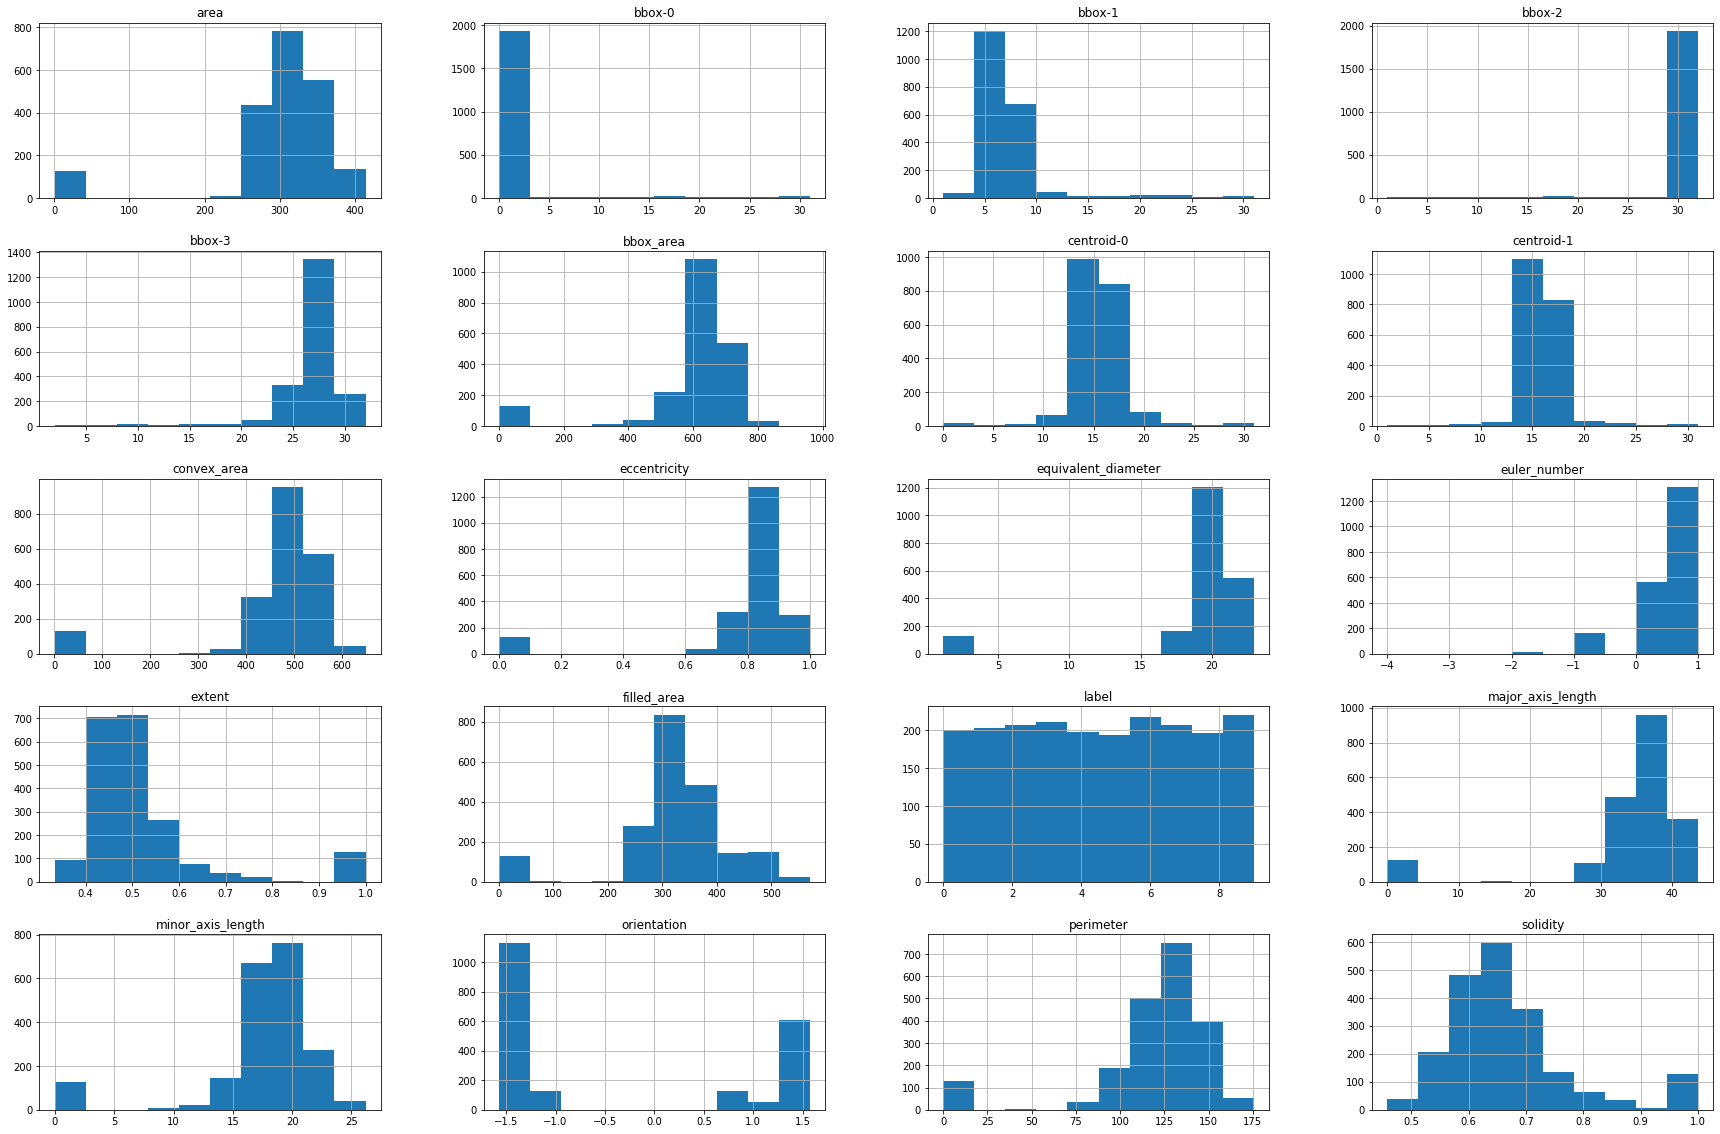

In [12]:
# drawing histograms for each column
df.hist(figsize=(30, 20))

In histograms, we can see that most features have outliers. Features that have obvious outliers: 
1. Area
2. Bbox area
3. Convex area
4. Eccentricity
5. Equivalent diameter
6. Extent
7. Filled area
8. Major axis length
9. Perimeter
10. Solidity

Ten of our features have outliers. Also, we can see that most of the features might have the same outliers because the number of outliers is very similar from feature to feature.

In this step, we will remove all entries where the area is less than 200 to remove outliers. we have chosen an area of 200 because if the area is less than 200 probably it is an extra region from the image feature extraction phase.

In [13]:
# removing outliers
df = df[df['area'] > 200]
df.describe()

,area,perimeter,orientation,euler_number,major_axis_length,bbox_area,eccentricity,convex_area,equivalent_diameter,extent,filled_area,minor_axis_length,solidity,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,label
count,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000
mean,318.620115,127.319520,-0.431867,0.512767,36.222411,653.304846,0.847488,495.312142,20.111459,0.492498,345.801459,18.699678,0.646877,15.459900,15.833639,0.055237,6.235018,31.959875,26.706618,4.532569
std,34.876141,17.289241,1.355999,0.691614,3.176890,67.486625,0.055998,48.611460,1.099811,0.072763,63.122542,2.402612,0.074624,1.646831,1.161034,0.423591,1.304721,0.201546,1.683172,2.868850
min,202.000000,69.941125,-1.570455,-4.000000,22.825093,320.000000,0.615661,241.000000,16.037281,0.334239,202.000000,8.778309,0.458188,10.823529,12.100746,0.000000,1.000000,30.000000,20.000000,0.000000
25%,292.000000,117.018290,-1.466142,0.000000,34.201412,640.000000,0.814796,466.000000,19.281752,0.442434,301.000000,17.221557,0.595090,14.425202,15.046209,0.000000,5.000000,32.000000,26.000000,2.000000
50%,318.000000,127.982756,-1.335585,1.000000,36.306877,640.000000,0.860088,498.000000,20.121883,0.481250,333.000000,18.699232,0.642722,15.402439,15.765363,0.000000,6.000000,32.000000,27.000000,5.000000
75%,343.000000,139.503571,1.366834,1.000000,38.445244,704.000000,0.888060,529.000000,20.897875,0.526563,371.000000,20.201417,0.688933,16.425725,16.536593,0.000000,7.000000,32.000000,28.000000,7.000000
max,414.000000,175.580736,1.570704,1.000000,43.637847,960.000000,0.969039,649.000000,22.959120,0.892857,570.000000,26.195699,0.961538,24.013514,20.280936,16.000000,11.000000,32.000000,32.000000,9.000000


Removing outliers based on one feature also removed outliers from other features. We can already see that minimum values make much more sense. There are no obvious outliers that we can see from dataset statistics. in order to confirm that we plotted boxplots and histograms again to see how these graphs have changed.

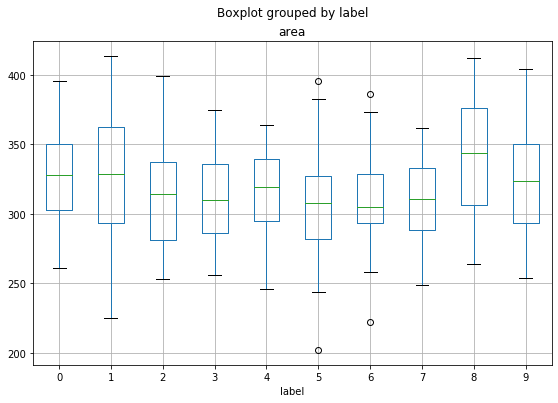

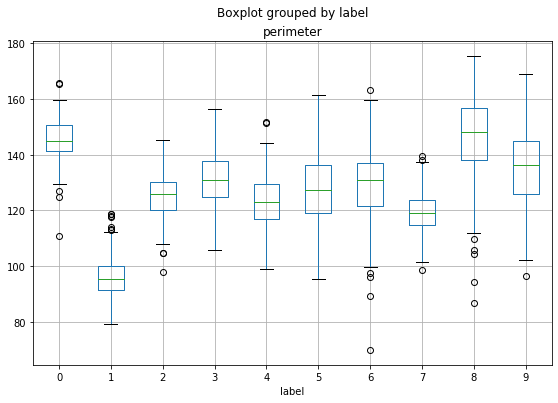

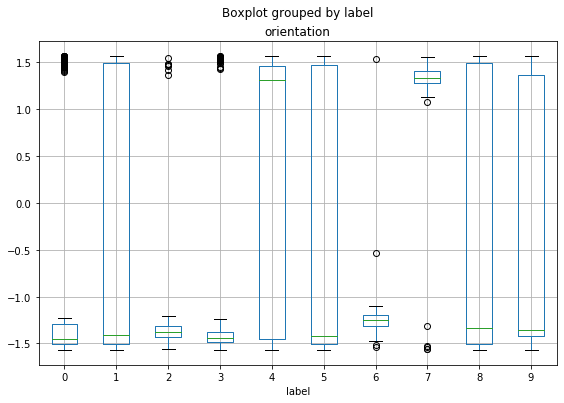

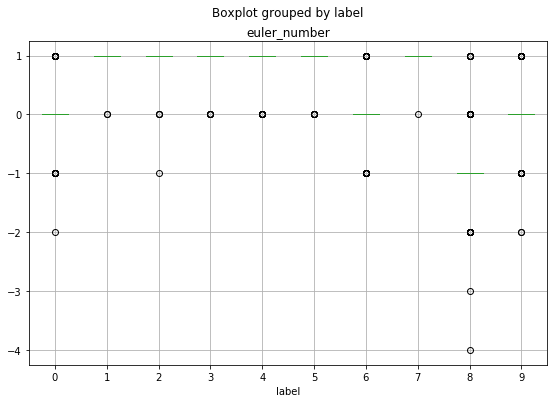

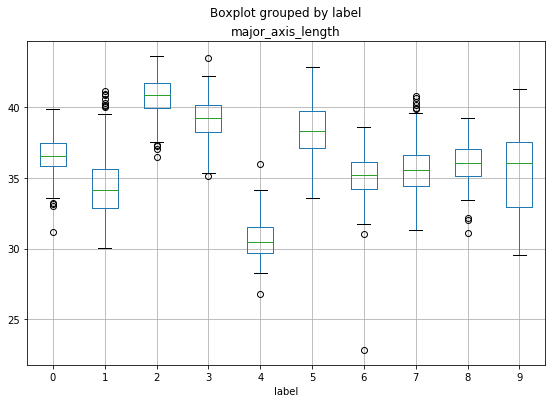

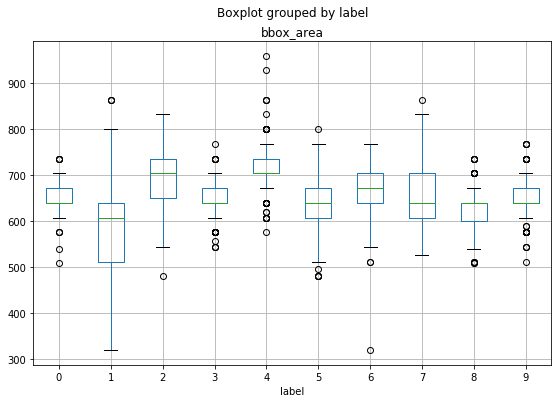

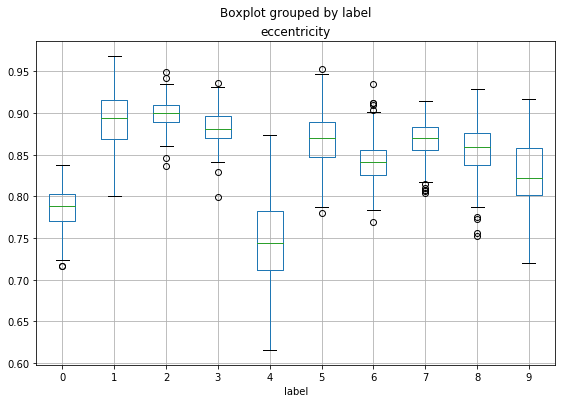

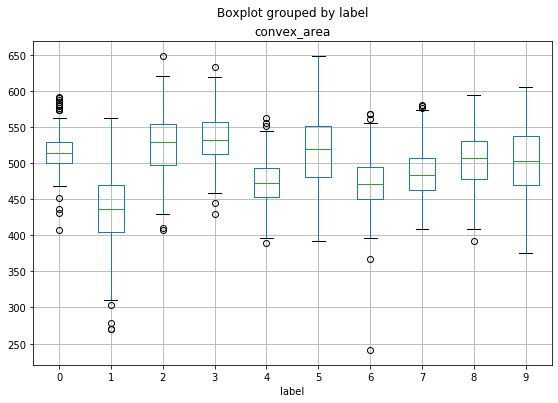

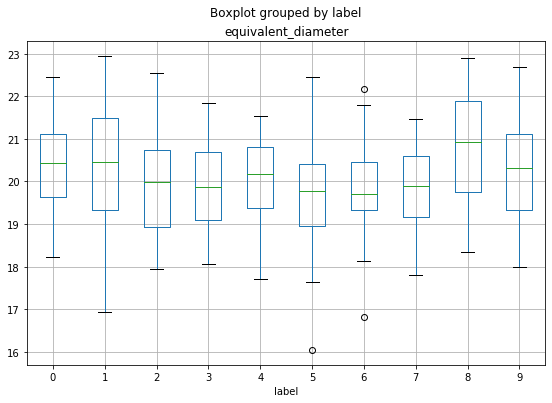

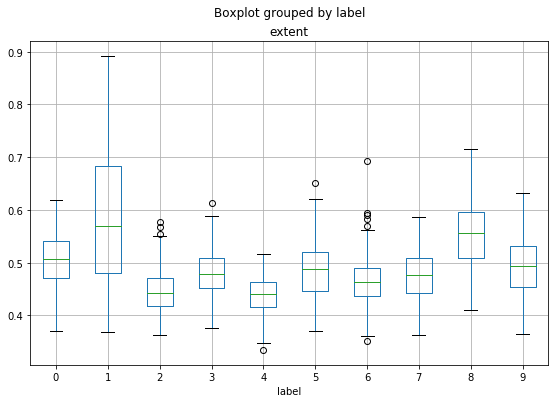

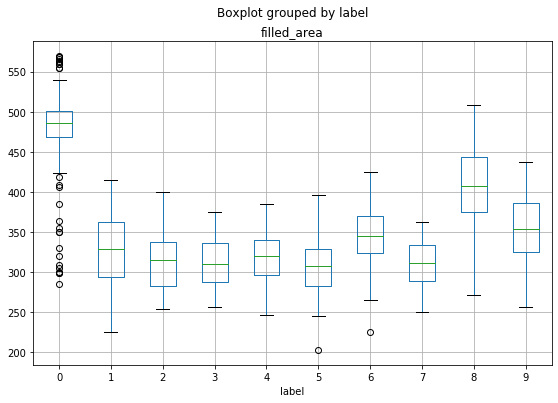

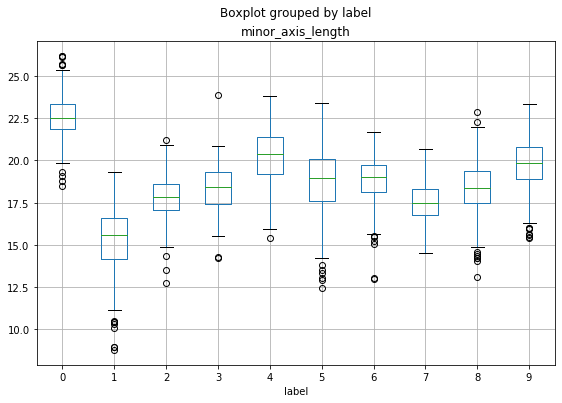

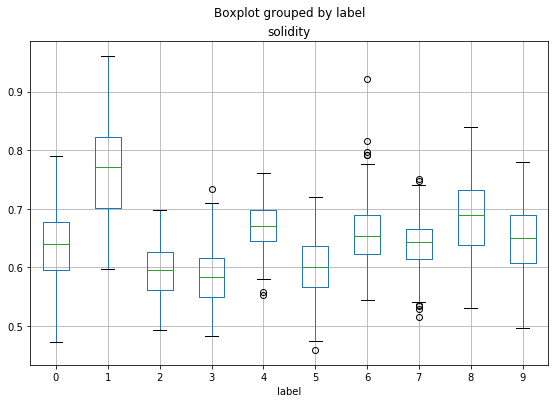

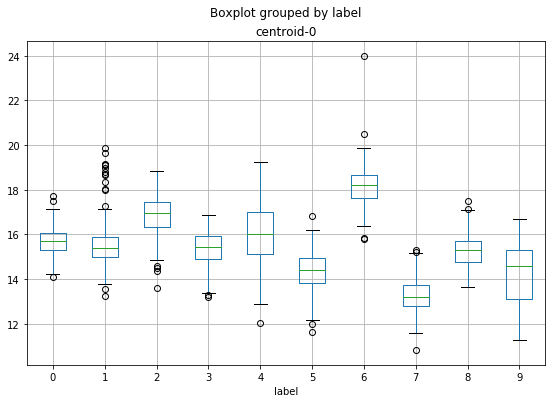

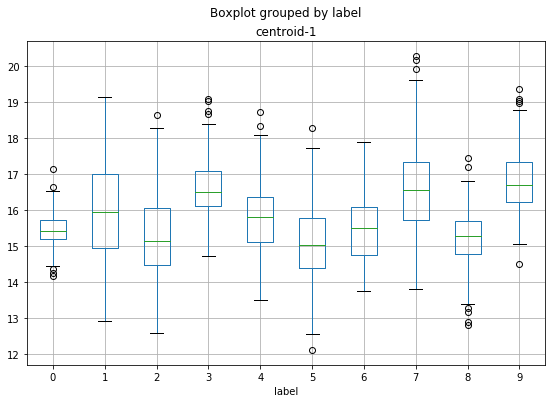

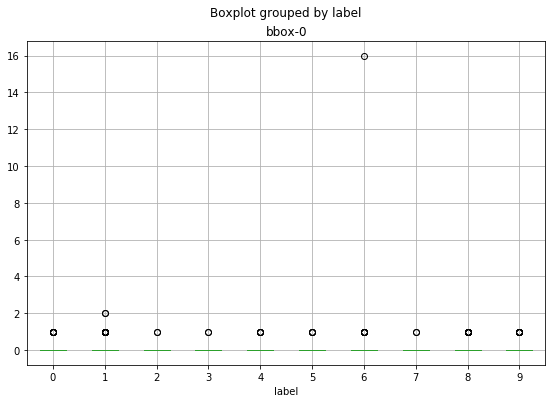

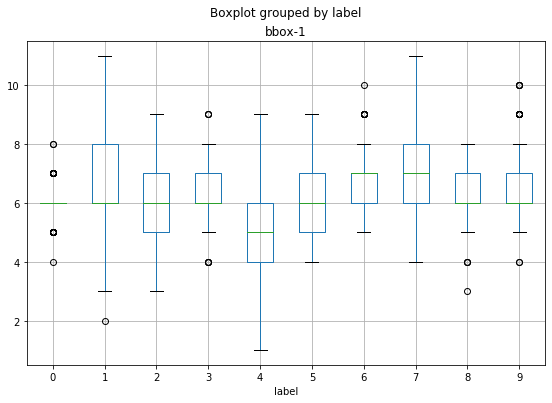

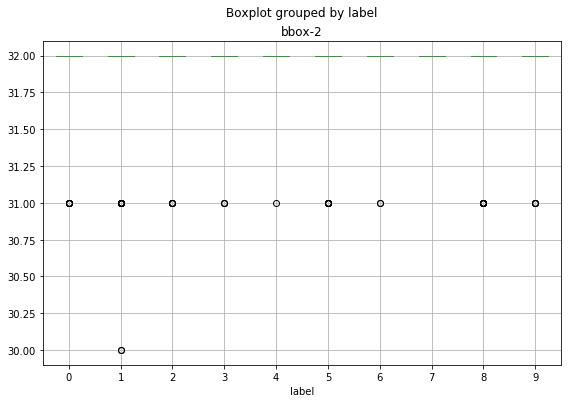

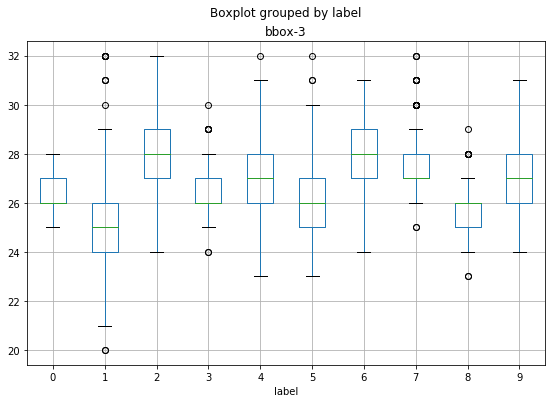

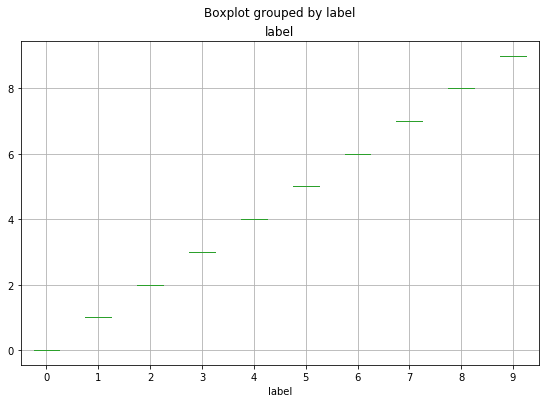

In [14]:
# Checkong how boxplot graphs changed after removal of outliers
for column in df.columns:
    df.boxplot([column], by='label',  figsize=(9, 6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CAA5F7D108>,
      dtype=object)

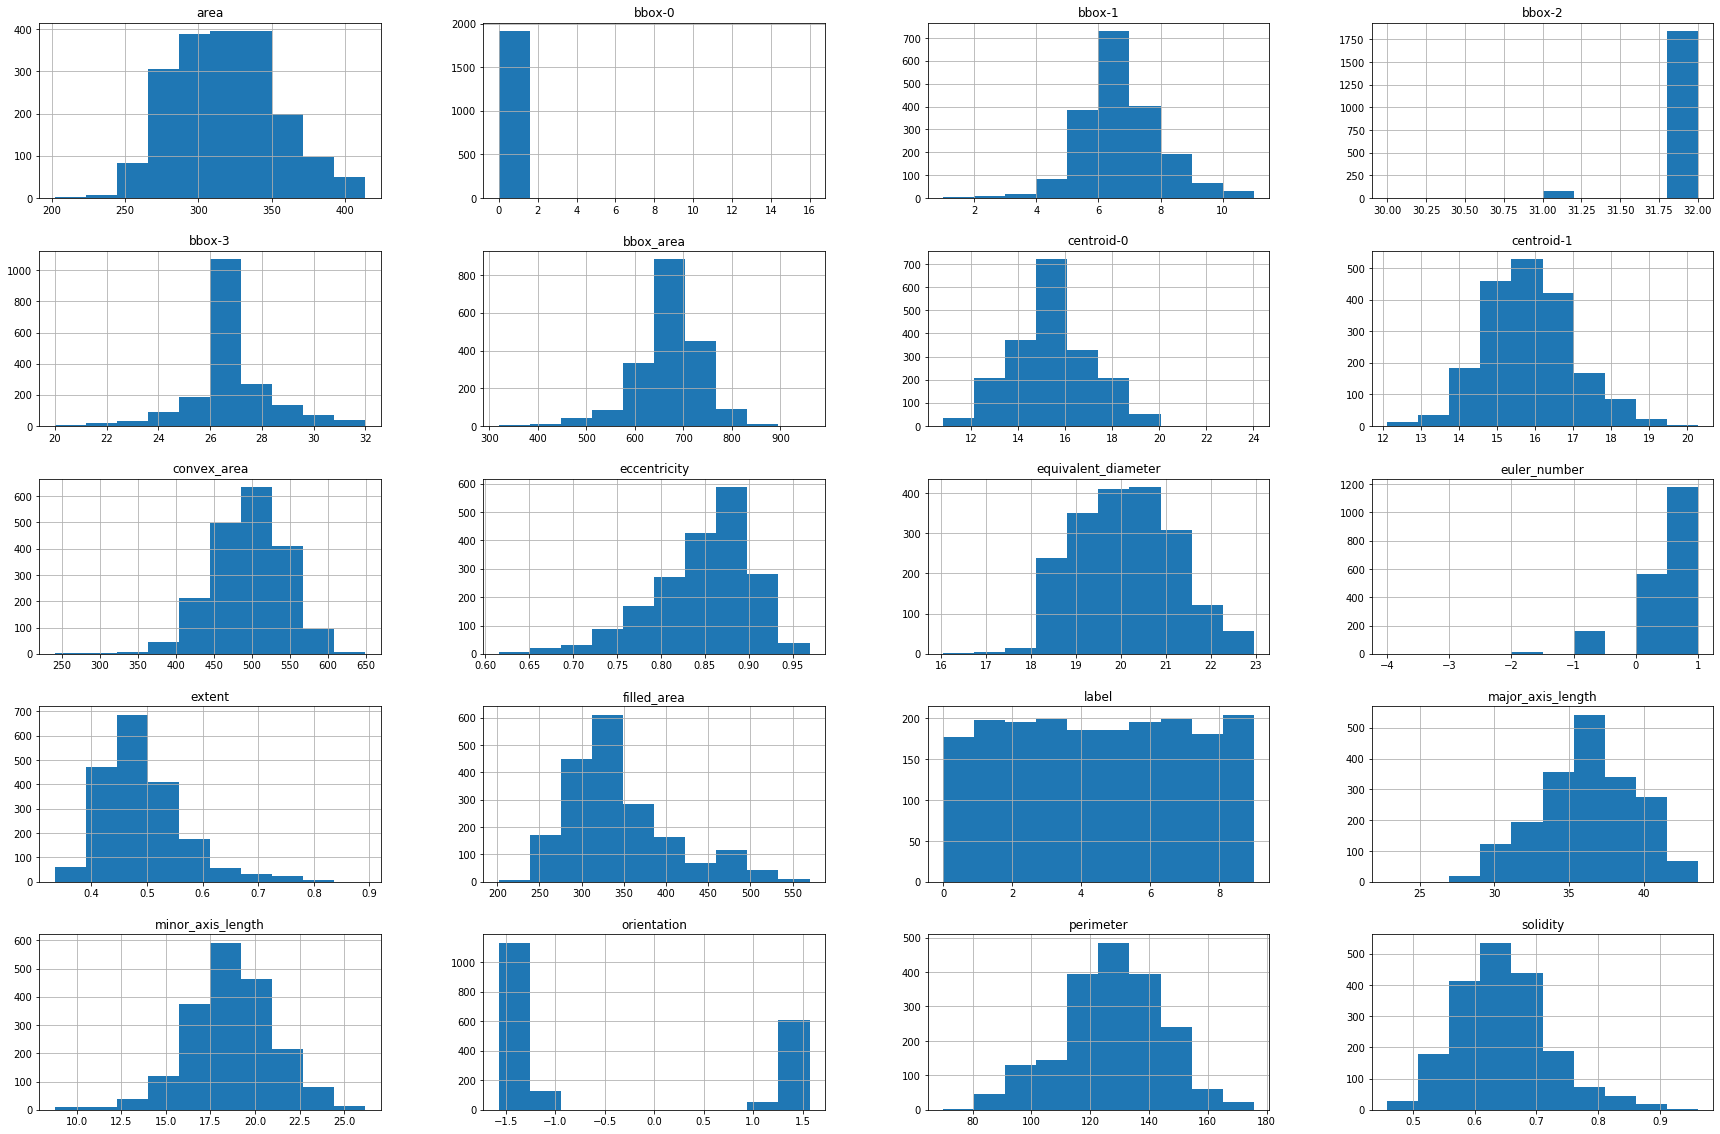

In [15]:
# Checkong how histogram graphs changed after removal of outliers
df.hist(figsize=(30, 20))

As we can see from the plots we have a lot fewer outliers. Furthermore, we can see that it should be possible to differentiate amongst different labels using a combination of different features. Also, it is clear which features do not offer any meaningful information for classification. these features are equivalent diameter, bbox-0, and bbox-2. Other features should offer some useful insight for the classification algorithm.

Next, we looked at the correlation matrix in order to see which features are highly correlated and remove them. There is no point having features that are highly correlated because they will have no or very little impact on the classification result but it will have an impact on processing speed. We have decided to remove all features over 80% correlation or below 80 % correlation.

In [16]:
# Checkong how corrolation changed after removal of outliers
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,area,perimeter,orientation,euler_number,major_axis_length,bbox_area,eccentricity,convex_area,equivalent_diameter,extent,filled_area,minor_axis_length,solidity,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,label
area,1,0.0919078,0.0101689,-0.181831,-0.0859885,0.180288,-0.189828,0.415387,0.999435,0.625036,0.618954,0.233326,0.578822,0.0182059,-0.0245615,-0.00164927,-0.18629,-0.123221,0.0879207,0.0141594
perimeter,0.0919078,1,-0.148998,-0.561564,0.254182,0.335261,-0.367304,0.635849,0.0958388,-0.236659,0.507398,0.719607,-0.50027,0.0599495,0.00286012,-0.139589,-0.176558,0.172924,0.253455,0.245405
orientation,0.0101689,-0.148998,1,0.0763972,-0.286582,-0.0384376,-0.107645,-0.201098,0.00834613,0.0569295,-0.0875728,-0.0994043,0.179542,-0.459054,0.0450042,-0.00704691,0.0427026,0.00832941,-0.0174507,0.203774
euler_number,-0.181831,-0.561564,0.0763972,1,0.0878604,0.071681,0.195045,-0.0579703,-0.179049,-0.161053,-0.589249,-0.276334,-0.0968186,-0.111321,0.0838605,-0.038002,-0.0411721,-0.00941426,0.051814,-0.403368
major_axis_length,-0.0859885,0.254182,-0.286582,0.0878604,1,0.0313323,0.627444,0.559323,-0.0845342,-0.105947,-0.0484658,-0.0723802,-0.55746,0.0860214,-0.0700679,-0.163664,0.133845,0.114394,0.111143,-0.156964
bbox_area,0.180288,0.335261,-0.0384376,0.071681,0.0313323,1,-0.431627,0.539994,0.188402,-0.637926,0.0890111,0.553054,-0.341876,0.163241,0.108015,-0.240206,-0.56699,0.267191,0.762563,0.0352302
eccentricity,-0.189828,-0.367304,-0.107645,0.195045,0.627444,-0.431627,1,-0.120756,-0.193006,0.194603,-0.410112,-0.788025,-0.0461834,-0.00314673,-0.0638411,-0.00667204,0.404722,-0.048014,-0.226473,-0.0316409
convex_area,0.415387,0.635849,-0.201098,-0.0579703,0.559323,0.539994,-0.120756,1,0.420793,-0.134636,0.358813,0.602522,-0.492615,-0.00154203,0.0612501,-0.185624,-0.311873,0.135861,0.399556,0.0150626
equivalent_diameter,0.999435,0.0958388,0.00834613,-0.179049,-0.0845342,0.188402,-0.193006,0.420793,1,0.618148,0.618492,0.238823,0.573674,0.019788,-0.0238359,-0.00764855,-0.190462,-0.121065,0.0937945,0.0140795
extent,0.625036,-0.236659,0.0569295,-0.161053,-0.105947,-0.637926,0.194603,-0.134636,0.618148,1,0.381612,-0.283906,0.748312,-0.0891318,-0.113143,0.226612,0.300086,-0.348495,-0.513709,-0.0490672


## Export labels

Now that we have a complete dataset where outliers have been removed we exported labels of the dataset to the separate .pkl file. this file will be loaded in the next phase and will be used for training, testing, and validation.

In [17]:
# Exporting dataset labels. To be used in training and testing later on
labels = df['label'].to_numpy()
joblib.dump(labels, TEMP_DIR_PATH + '/datasets/label-dataset.pkl')

['../temp/datasets/label-dataset.pkl']

## Manual feature selection

Based on the correlation matrix and histograms we have decided to remove these features: 
  1. equivalent diameter - due to high correlation with area feature
  2. bbox-0 - due to the very small distribution observed in histogram
  3. bbox-2 - due to the very small distribution observed in histogram

In [18]:
# Manual feature removal
df_mnl = df.drop(['equivalent_diameter', 'bbox-0', 'bbox-2'], axis=1)

## Manual feature pre-processing 


To classify entries of the dataset features must be scaled. This is important to have all features that have the same weight in most classification algorithms. We have selected to use Normalization (MinMaxScaler)
instead of Standardization because we already removed obvious outliers and we wanted to maintain our scale between entries. Furthermore, most of our features already are normally distributed.

In [19]:
# Scale manualy selected features
X_mnl_df = df_mnl.iloc[:, df_mnl.columns != 'label'].reindex()

scaler = MinMaxScaler()
X_mnl_scld = scaler.fit_transform(X_mnl_df)

After we have scaled our features we export them to the .pkl file alongside the scaler that was used. Scaler export needed for scaling new images to use in classifier after it was trained.

In [20]:
# Export dataset and scaler. Dataset will be used in training and testing in the next step
if not os.path.isdir(TEMP_DIR_PATH + "/datasets"):
  os.mkdir(TEMP_DIR_PATH + "/datasets")

if not os.path.isdir(TEMP_DIR_PATH + "/preprocessors"):
  os.mkdir(TEMP_DIR_PATH + "/preprocessors")

joblib.dump(X_mnl_scld, TEMP_DIR_PATH + '/datasets/manualy-selected-feature-dataset.pkl')
joblib.dump(scaler, TEMP_DIR_PATH + '/preprocessors/manual-image-feature-preprocessor.pkl')

['../temp/preprocessors/manual-image-feature-preprocessor.pkl']

## Auto feature selection

Also, we have decided to use auto feature selection sklearn to see if automatically selected features would yield better results. The first step to auto feature selection is the scaling dataset. Same as for manual feature selection we are using MinMaxScaler. After that, we are using the SelectKBest module from the sklearn. This module has two hyperparameters: score_func and k.
score_func is a method used for scoring each feature how useful it is and k is the number of features we want to be remaining in the final dataset. For our score_func we have selected to use "chi2" and "f_classif" because these functions are used to select the best features for classification task. For our k we decided to use 16, to make our manually selected feature amount and automatically selected feature amount be the same. In the next phase, we will test both datasets from "chi2" and "f_classif" and see which is better in for this problem.

In [21]:
# Scale features
X_auto_df = df.iloc[:, df.columns != 'label']

scaler = MinMaxScaler()
X_auto_scld = scaler.fit_transform(X_auto_df)

In [22]:
# select best features out of the dataset
skb_chi2 = SelectKBest(chi2, k=16)
X_auto_chi2 = skb_chi2.fit_transform(X_auto_scld, labels)

In [23]:
skb_f_classif = SelectKBest(f_classif, k=16)
X_auto_f_classif = skb_f_classif.fit_transform(X_auto_scld, labels)

Same as with manual features we need to export selected features and scalers. Besides them, we need to export two SelectKBest modules that were already fitted. This is required in order to extract the best features from new images that will be uploaded.

In [24]:
joblib.dump(scaler, TEMP_DIR_PATH + '/preprocessors/auto-image-feature-preprocessor.pkl')

['../temp/preprocessors/auto-image-feature-preprocessor.pkl']

In [25]:
if not os.path.isdir(TEMP_DIR_PATH + "/selection"):
  os.mkdir(TEMP_DIR_PATH + "/selection")

In [26]:
# Export dataset, scaler and feature selector. Dataset will be used in training and testing in the next step
joblib.dump(X_auto_chi2, TEMP_DIR_PATH + '/datasets/auto-selected-features-chi2.pkl')
joblib.dump(skb_chi2, TEMP_DIR_PATH + '/selection/auto-image-feature-selector-chi2.pkl')

['../temp/selection/auto-image-feature-selector-chi2.pkl']

In [27]:
# Export dataset, scaler and feature selector. Dataset will be used in training and testing in the next step
joblib.dump(X_auto_f_classif, TEMP_DIR_PATH + '/datasets/auto-selected-features-f-classif.pkl')
joblib.dump(skb_f_classif, TEMP_DIR_PATH + '/selection/auto-image-feature-selector-f-classif.pkl')

['../temp/selection/auto-image-feature-selector-f-classif.pkl']

# Cleanup
Ensure no data is left on the runtime after execution of all code has completed. This ensures we won't re-use old data once something in the code has changed, eliminating the risk of hours of debugging functional code.

In [28]:
# # Remove all data from the /content directory
# if os.path.isdir(DATASET_CSV_PATH):
#   shutil.rmtree(DATASET_CSV_PATH)